In [1]:
import cv2
import numpy as np

from ultralytics import YOLO
from sort_master.sort import Sort
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (None) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


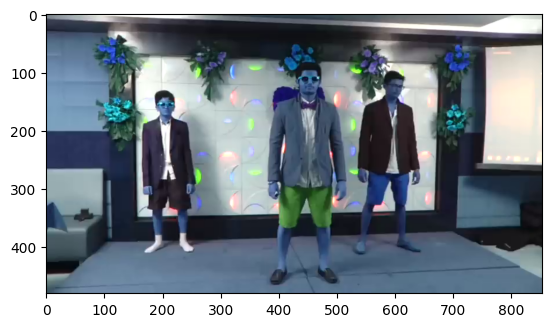

In [2]:
vid = cv2.VideoCapture("videoplayback.mp4")
ret, frame = vid.read()

plt.imshow(frame)

In [3]:
model = YOLO("yolov8n.pt")

results = model(frame)
results

/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0: 384x640 3 persons, 2 ties, 1 couch, 3 potted plants, 1 tv, 63.8ms
Speed: 5.9ms preprocess, 63.8ms inference, 1043.6ms postprocess per image at shape (1, 3, 384, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [4]:
detection_threshold = 0.8
tracker = Sort()

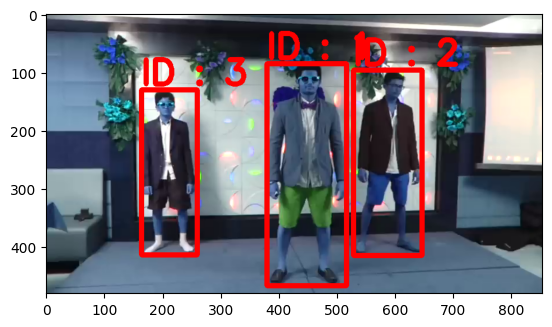

In [9]:
outp = frame.copy()
minx1 , miny1 , maxx2 , maxy2 = float("inf"),float("inf"),0,0
for result in results:
    detections = []
    for r in result.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = r
        x1 = int(x1)
        x2 = int(x2)
        y1 = int(y1)
        y2 = int(y2)
        class_id = int(class_id)
        if score > detection_threshold:
            detections.append([x1, y1, x2, y2, score , class_id])
    detections = np.array(detections)
    track_bbs_ids = tracker.update(detections)


    for track in track_bbs_ids:
        # bbox = track.bbox
        # x1, y1, x2, y2 = bbox
        # track_id = track.track_id
        x1, y1, x2, y2, id = list(map(int , track.tolist()))
        minx1 = min(minx1 , x1)
        miny1 = min(miny1 , y1)
        maxx2 = max(maxx2 , x2)
        maxy2 = max(maxy2 , y2)
        name = f"ID : {id}"
        color = (255,0,0)
        cv2.rectangle(outp, (int(x1), int(y1)), (int(x2), int(y2)), color , 7)
        cv2.putText(outp , name , (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 2 , color , 7)
        # print(track)
plt.imshow(outp)

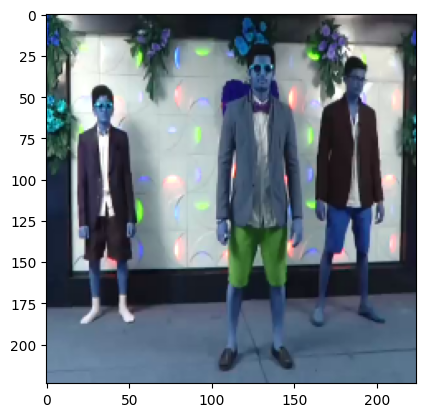

In [20]:
ext = 1.2 #extend video by 1.5x

midx = (maxx2+minx1)//2
midy = (maxy2+miny1)//2

extx = int((maxx2-minx1) * ext)
exty = int((maxy2-miny1) * ext)

cropx1 = max(midx - extx//2 , 0)
cropx2 = min(midx + extx//2 , frame.shape[1])
cropy1 = max(midy - exty//2 , 0)
cropy2 = min(midy + exty//2 , frame.shape[0])

x = frame[cropy1:cropy2 , cropx1:cropx2]
x = cv2.resize(x , (224,224))
plt.imshow(x)

# midx , midy , extx , exty , minx1 , miny1 , maxx2 , maxy2

In [21]:
frames = []
video = cv2.VideoCapture("videoplayback.mp4")
while True:
    read, frame= video.read()
    if not read:
        break
    frames.append(frame)
frames = np.array(frames)

frames.shape

(3088, 480, 854, 3)

In [24]:
CLIP_SIZE = 32
w , h = frames.shape[1:3]
# BATCH_SIZE = 1
frame_size = frames.shape[0]
num_batches = (frame_size // 32)
clipped_frames_size = num_batches * 32
clipped_frames = frames[:clipped_frames_size]
clipped_frames = clipped_frames.reshape(num_batches , 32 , w , h , 3)
clipped_frames = np.rollaxis(clipped_frames, 4, 1)
# # clipped_frames = clipped_frames[np.newaxis , ...]
# clipped_frames = clipped_frames.astype(np.float32)
clipped_frames = clipped_frames.astype(np.uint8)
clipped_frames = np.average(clipped_frames , axis=0)
print("Video Averaged every 32 frames : ", clipped_frames.shape)

Video Averaged every 32 frames :  (3, 32, 480, 854)


### Combining (Complete Preprocessing)

In [38]:
frames = []
video = cv2.VideoCapture("videoplayback.mp4")
while True:
    read, frame= video.read()
    if not read:
        break
    outp = frame
    minx1 , miny1 , maxx2 , maxy2 = float("inf"),float("inf"),0,0
    for result in results:
        detections = []
        for r in result.boxes.data.tolist():
            x1, y1, x2, y2, score, class_id = r
            x1 = int(x1)
            x2 = int(x2)
            y1 = int(y1)
            y2 = int(y2)
            class_id = int(class_id)
            if score > detection_threshold:
                detections.append([x1, y1, x2, y2, score , class_id])
        detections = np.array(detections)
        track_bbs_ids = tracker.update(detections)


        for track in track_bbs_ids:
            # bbox = track.bbox
            # x1, y1, x2, y2 = bbox
            # track_id = track.track_id
            x1, y1, x2, y2, id = list(map(int , track.tolist()))
            minx1 = min(minx1 , x1)
            miny1 = min(miny1 , y1)
            maxx2 = max(maxx2 , x2)
            maxy2 = max(maxy2 , y2)
            name = f"ID : {id}"
            color = (255,0,0)
            # cv2.rectangle(outp, (int(x1), int(y1)), (int(x2), int(y2)), color , 7)
            # cv2.putText(outp , name , (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 2 , color , 7)
            # print(track)
            
    ext = 1.2 #extend video by 1.5x
    midx = (maxx2+minx1)//2
    midy = (maxy2+miny1)//2

    extx = int((maxx2-minx1) * ext)
    exty = int((maxy2-miny1) * ext)

    cropx1 = max(midx - extx//2 , 0)
    cropx2 = min(midx + extx//2 , frame.shape[1])
    cropy1 = max(midy - exty//2 , 0)
    cropy2 = min(midy + exty//2 , frame.shape[0])

    frame = frame[cropy1:cropy2 , cropx1:cropx2]
    frame = cv2.resize(frame , (224,224))
    frames.append(frame)
frames = np.array(frames)

CLIP_SIZE = 32
w , h = frames.shape[1:3]
# BATCH_SIZE = 1
frame_size = frames.shape[0]
num_batches = (frame_size // 32)
clipped_frames_size = num_batches * 32
clipped_frames = frames[:clipped_frames_size]
clipped_frames = clipped_frames.reshape(num_batches , 32 , w , h , 3)
clipped_frames = np.rollaxis(clipped_frames, 4, 1)
# # clipped_frames = clipped_frames[np.newaxis , ...]
# clipped_frames = clipped_frames.astype(np.float32)
clipped_frames = np.average(clipped_frames , axis=0)
clipped_frames = clipped_frames.astype(np.uint8)
print(f"Video Averaged every {num_batches} frames : ", clipped_frames.shape)

clipped_frames.shape
# plt.imshow(clipped_frames[0])

Video Averaged every 96 frames :  (3, 32, 224, 224)


(3, 32, 224, 224)

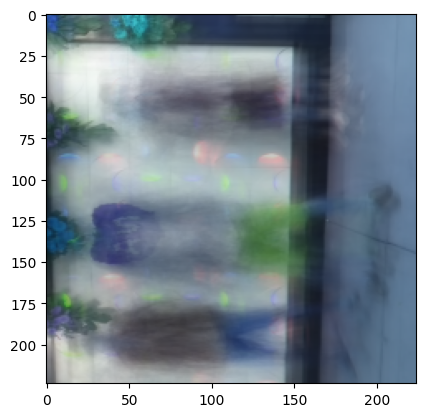

In [43]:
x = clipped_frames.T
x = np.rollaxis(x, 2, 0)

# plt.imshow(x[1])
plt.imshow(x[0])